# Prediksi Curah Hujan di Kota Jambi Menggunakan Algoritma *RNN*





importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

membaca file csv dan membuat kolom "bulan" 

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# autentikasi dan membuat klien PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1lDgBwtxlhY2MiackPnI5n4KnJuESGjmt/view?usp=sharing'
 
# mengambil id file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('curah-hujan-jambi.csv') 
 
df = pd.read_csv('curah-hujan-jambi.csv', index_col = 'bulan',parse_dates = True)
df.index.freq = 'MS'

mengambil data dari file

In [ ]:
df.head()

,curah hujan (mm)
bulan,
2017-01-01,90
2017-02-01,117
2017-03-01,201
2017-04-01,146
2017-05-01,270


membuat plot dari data-data file

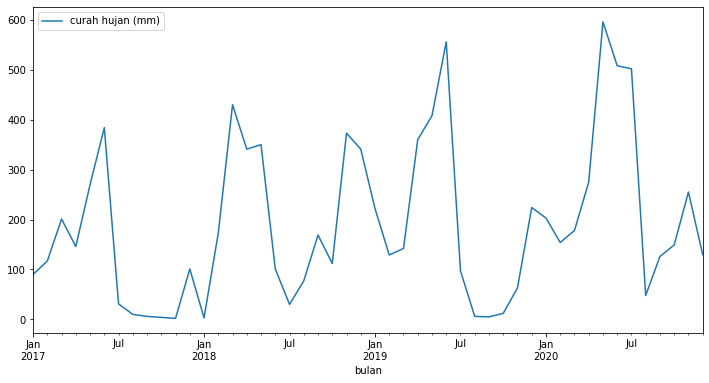

In [ ]:
df.plot(figsize = (12, 6))

decompose bagian-bagian dari series waktu dan menunjukkan trend

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

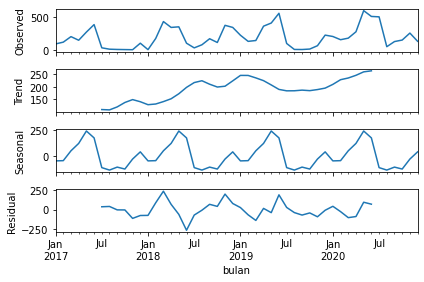

In [ ]:
results = seasonal_decompose(df['curah hujan (mm)'])
results.plot();

mengecek ukuran dari data set

In [ ]:
len(df)

48

mengabil 36 data untuk training dan testing

In [ ]:
train = df.iloc[:36]
test = df.iloc[36:]

mengubah nilai menjadi skala 0 sampai 1 dari data set

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(), df.tail()

(            curah hujan (mm)
 bulan                       
 2017-01-01                90
 2017-02-01               117
 2017-03-01               201
 2017-04-01               146
 2017-05-01               270,             curah hujan (mm)
 bulan                       
 2020-08-01                48
 2020-09-01               126
 2020-10-01               149
 2020-11-01               255
 2020-12-01               130)

transformasi data menggunakan scaler function menjadi skala 0 dan 1

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.15884477],
       [0.20758123],
       [0.35920578],
       [0.2599278 ],
       [0.48375451],
       [0.68953069],
       [0.05234657],
       [0.01444043],
       [0.00722022],
       [0.00361011]])

membuat model prediksi, waktu 3 bulan

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# mendefinisikan generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [ ]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediksi y: \n {y}')

Array: 
[0.15884477 0.20758123 0.35920578]
Prediksi y: 
 [[0.2599278]]


In [ ]:
X.shape

(1, 3, 1)

In [ ]:
# kita ulangi prosesnya untuk 12 bulan
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

import libraries

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [ ]:
# mendefinisikan model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

arsitektur dari model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs = 50)

Epoch 1/50
24/24 [==============================] - 2s 8ms/step - loss: 0.1365
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0848
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0864
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0911
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0818
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0813
Epoch 7/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0842
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0831
Epoch 9/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0764
Epoch 10/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0752
Epoch 11/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0741
Epoch 12/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0728
Epoch 13/50
24/24 [============================

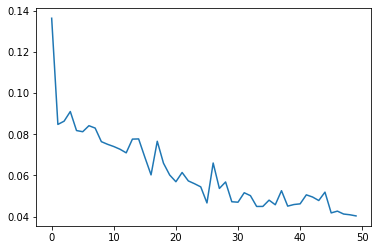

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

mengambil 12 bulan terakhir training set untuk nilai pertama testing set

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.5451812]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.36281588])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # nilai prediksi untuk kelompok pertama 
    current_pred = model.predict(current_batch)[0]
    
    # menambahkan hasil prediksi ke array
    test_predictions.append(current_pred) 
    
    # menggunakan hasil prediksi untuk mengubah kelompok pertama dan menghapus nilai pertama
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

In [ ]:
test_predictions

[array([0.5451812], dtype=float32),
 array([0.62217295], dtype=float32),
 array([0.56241477], dtype=float32),
 array([0.41198784], dtype=float32),
 array([0.328232], dtype=float32),
 array([0.34108508], dtype=float32),
 array([0.35845232], dtype=float32),
 array([0.40953344], dtype=float32),
 array([0.46192282], dtype=float32),
 array([0.47776264], dtype=float32),
 array([0.44917023], dtype=float32),
 array([0.4177397], dtype=float32)]

In [ ]:
test.head()

,curah hujan (mm),Predictions
bulan,,
2020-01-01,203,304.030393
2020-02-01,154,346.683815
2020-03-01,178,313.577780
2020-04-01,275,230.241264
2020-05-01,596,183.840523


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


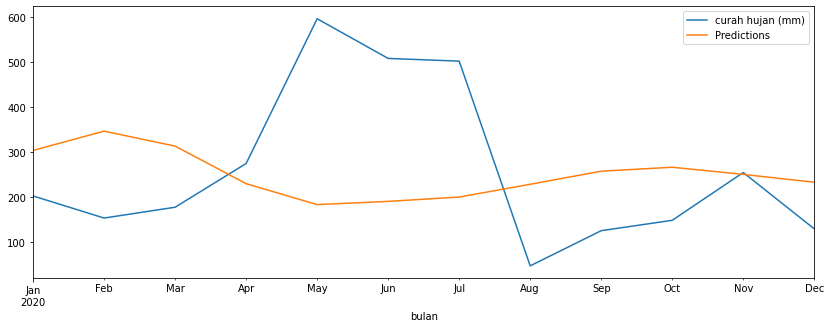

In [ ]:
test.plot(figsize = (14, 5))

mengecek besar nilai error dari model

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['curah hujan (mm)'],test['Predictions']))
print(rmse)

204.86598042876733
